In [67]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import pickle
import networkx as nx

from statistics import mean, stdev, median

In [71]:
# Read in text data
data_path = "data/title/train.tsv.gz"
data = pd.read_csv(data_path, sep="\t", compression="gzip", header=0, names=["title", "label-idn"])
gnd = pickle.load(open("data/gnd.pickle", "rb"))

In [72]:
def strip_uri(x):
    x = x.split()
    idns_only = []
    for idn in x:
        idn = idn.removesuffix(">").removeprefix("<http://d-nb.info/gnd/")
        idns_only.append(idn)
    return idns_only
    

In [73]:
data["label-idn"] = data["label-idn"].apply(strip_uri)

In [74]:
data.sample(5, random_state=10)

,title,label-idn
587925,Wichtige Mietgesetze mit Vorschriften der Wohn...,[040747816]
704853,"Aristokratinnen vier Schwestern, die ein Jahrh...","[119361949, 119361965, 119362031, 11936204X]"
401727,Glasmalerei Glaube - Kunst - Kirche,"[040211770, 040734366]"
115797,Lebensweisheiten berühmter Dichter und Denker...,[04117724X]
457994,Beirut im Sommer Journal,"[040176045, 040355675, 1041651422]"


## Avg. Number of Labels per Title

In [75]:
data["num_gnds"] = data["label-idn"].apply(len)
# Avergae number of GNDs per title
print(f"Average number of GNDs per title: {data['num_gnds'].mean()}")

Average number of GNDs per title: 2.7629972778973464


## Avg. Word Length

In [91]:
data["tokenized"] = data["title"].apply(word_tokenize)
data["title-length"] = data["tokenized"].apply(len)

In [14]:
# Average title length
print(f"Mean: {data['title-length'].mean()}")
print(f"Standard Deviation: {data['title-length'].std()}")
print(f"Median: {data['title-length'].median()}")

Mean: 9.98398911579503
Standard Deviation: 7.234005195515456
Median: 9.0


Text(0.5, 0, 'Title Length')

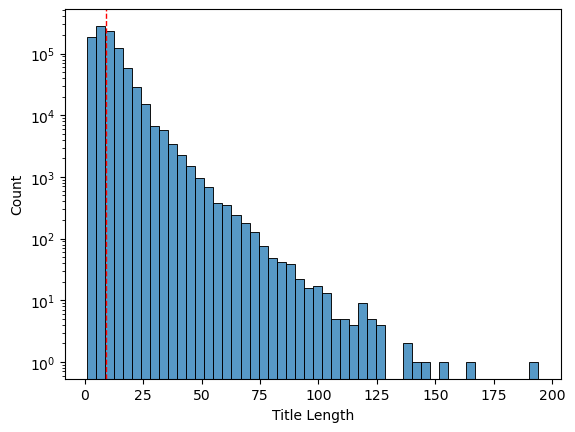

In [15]:
# histogram of title lengths
sns.histplot(data["title-length"], bins=50)
# add median line
plt.axvline(data["title-length"].median(), color='r', linestyle='dashed', linewidth=1)
plt.yscale("log")
plt.xlabel("Title Length")

## Zipf Distribution

In [19]:
freq_labels = {}

for idns in data["label-idn"]:
    for idn in idns:
        if idn not in freq_labels:
            freq_labels[idn] = 0
        freq_labels[idn] += 1

In [20]:
# find max frequency
max_freq = max(freq_labels, key=freq_labels.get)
max_freq, freq_labels[max_freq]

('040118827', 83121)

In [21]:
freqs = sorted(freq_labels.values(), reverse=True)
rank = range(1, len(freqs) + 1)

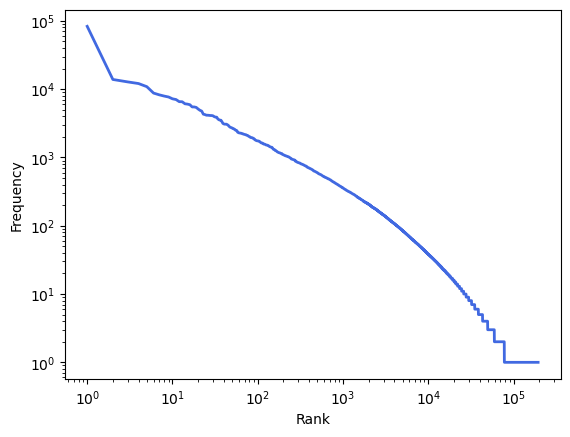

In [22]:
sns.lineplot(x=rank, y=freqs, color='royalblue', lw=2)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')   

## Avg. Number of title per label

In [23]:
print(f"Mean: {mean(freq_labels.values())}")
print(f"Median: {median(freq_labels.values())}")
print(f"Standard Deviation: {stdev(freq_labels.values())}")

Mean: 13.546967791158034
Median: 1.0
Standard Deviation: 220.51009524091117


## Token and Types

In [26]:
print(f"Total number of words in titles: {data['title-length'].sum()}")

Total number of words in titles: 9495802


In [27]:
types = set()
for tokens in tqdm(data["tokenized"]):
    for token in tokens:
        types.add(token)

  0%|          | 0/951103 [00:00<?, ?it/s]

100%|██████████| 951103/951103 [00:02<00:00, 469450.65it/s]


In [28]:
print(f"Number of unique words: {len(types)}")

Number of unique words: 705522


# Graph GND

### Label Types

In [76]:
rows = []
for idn, idn_data in gnd.nodes(data=True):
    row = {"idn": idn}
    row.update(idn_data)
    row["pref"] = list(row["pref"])[0]
    rows.append(row)
gnd_df = pd.DataFrame(rows)

In [43]:
ent_mapping = {
    "Sachbegriff": "Subject",
    "Person (individualisiert)": "Person",
    "Körperschaft": "Corporate Body",
    "Geografikum": "Geographic Location",
    "Werk": "Work",
    "Konferenz": "Conference",
}

[Text(0.5, 0, 'Entity type'), Text(0, 0.5, 'Frequency in GND')]

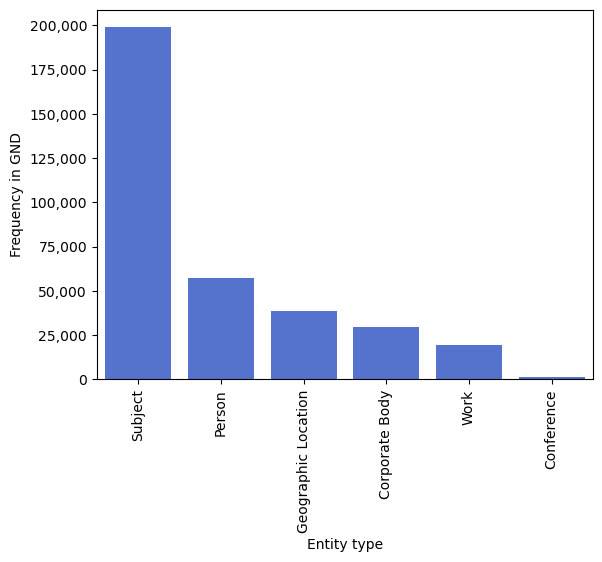

In [44]:
val_counts = dict(gnd_df.value_counts("type"))
names = map(ent_mapping.get, val_counts.keys())
ax = sns.barplot(
    x = list(names),
    y = list(val_counts.values()),
    color='royalblue'
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=90)
ax.set(xlabel='Entity type', ylabel='Frequency in GND')

In [81]:
label_frequency = [freq_labels.get(idn, 0) for idn in gnd_df["idn"]]
gnd_df["label_frequency"] = label_frequency

In [83]:
gnd_df.sort_values("label_frequency", ascending=False).head(10)[["pref", "label_frequency", "type"]]

,pref,label_frequency,type
580,Deutschland,83121,Geografikum
5176,Österreich,13850,Geografikum
965,Deutsch,12749,Sachbegriff
3960,Zeitschrift,12072,Sachbegriff
3686,Schweiz,10870,Geografikum
7872,Erster Weltkrieg,8758,Sachbegriff
3032,Literatur,8250,Sachbegriff
295,Europäische Union,7913,Körperschaft
15492,Kind,7670,Sachbegriff
9285,Frau,7217,Sachbegriff


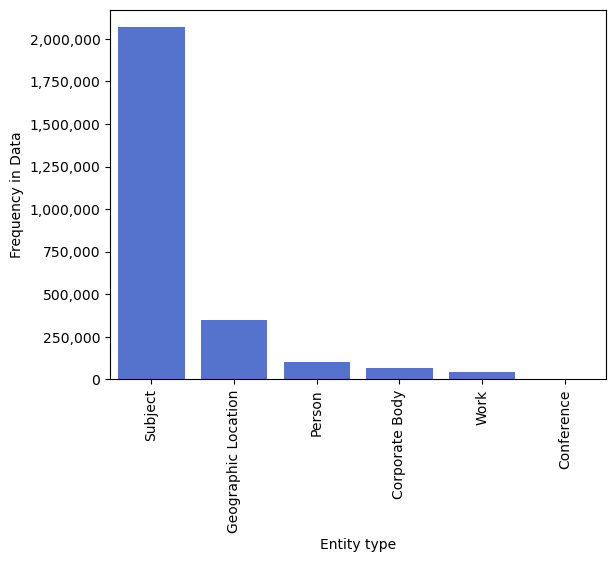

In [84]:
freq_by_type = gnd_df.groupby("type")["label_frequency"].sum()
freq_by_type = freq_by_type.sort_values(ascending=False)
names = list(map(ent_mapping.get, freq_by_type.index))
# plot
ax = sns.barplot(
    x = names,
    y = freq_by_type.values,
    color='royalblue', 
    order=names
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set(xlabel='Entity type', ylabel='Frequency in Data')
plt.xticks(rotation=90)
plt.show()

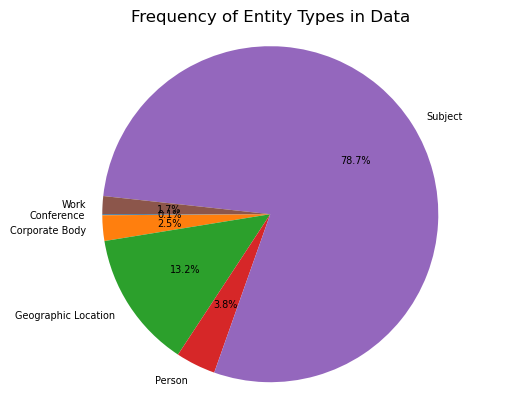

In [65]:
freq_data = gnd_df.groupby("type")["label_frequency"].sum() / gnd_df["label_frequency"].sum()
# set index
freq_data.index = list(map(ent_mapping.get, freq_data.index))
freq_data = freq_data.sort_index()
# pie chart
fig, ax = plt.subplots()
ax.pie(freq_data, labels=freq_data.index, autopct='%1.1f%%', startangle=180, textprops={'fontsize': 7})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Frequency of Entity Types in Data")
plt.show()


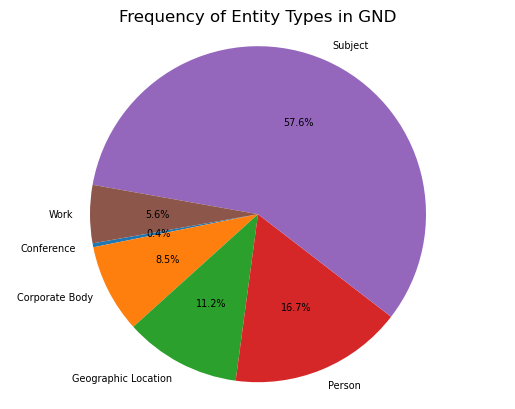

In [66]:
freq_gnd = gnd_df.value_counts("type") / gnd_df.shape[0]
freq_gnd.index = list(map(ent_mapping.get, freq_gnd.index))
# sort by name
freq_gnd = freq_gnd.sort_index()

fig, ax = plt.subplots()
ax.pie(freq_gnd, labels=freq_gnd.index, autopct='%1.1f%%', startangle=190, textprops={'fontsize': 7})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Frequency of Entity Types in GND")
plt.show()

In [202]:
from collections import deque

In [225]:
for n, node_data in gnd.nodes(data=True):
    q = deque()
    hierarchy = []
    if node_data.get("type") == "Sachbegriff":
        q.append([n])
        while q:
            current_path = q.popleft()
            last_node = current_path[-1]
            neighbors = list(gnd.neighbors(last_node))
            if len(neighbors) == 0:
                hierarchy.append(current_path)
            for ne in neighbors:
                rel_type = gnd.get_edge_data(last_node, ne)["relation"]
                n_type = gnd.nodes[ne].get("type")
                if rel_type == "broader" and n_type == "Sachbegriff":
                    new_path = current_path.copy()
                    new_path.append(ne)
                    q.append(new_path)
                else:
                    hierarchy.append(current_path)
        for p in hierarchy:
            print("->".join([list(gnd.nodes[n]["pref"])[0] for n in p]))


Tombakspiel->Trommelspiel->Schlaginstrumentenspiel->Instrumentalspiel
Unsinn
Unsinn->Sinnlosigkeit
Unsinn->Sinnlosigkeit
VC 1571->Diskettenlaufwerk->Laufwerk (Datentechnik)
Windows NT 3.5->Betriebssystem
Windows NT 3.5->Betriebssystem->Software
Betriebssystem
Betriebssystem->Software
COTS->Massengut->Produkt
COTS->Massengut->Produkt->Fertigungstechnik
COTS->Massengut->Produkt->Fertigungstechnik->Produktionstechnik
COTS->Massengut->Produkt->Fertigungstechnik->Produktionstechnik
COTS->Massengut->Produkt->Fertigungstechnik->Produktionstechnik->Ingenieurwissenschaften
COTS->Massengut->Produkt->Fertigungstechnik->Produktionstechnik->Ingenieurwissenschaften
COTS->Massengut->Produkt->Fertigungstechnik->Produktionstechnik->Ingenieurwissenschaften->Angewandte Wissenschaften->Wissenschaft
COTS->Massengut->Produkt->Fertigungstechnik->Produktionstechnik->Ingenieurwissenschaften->Angewandte Wissenschaften->Wissenschaft
COTS->Massengut->Produkt->Fertigungstechnik->Produktionstechnik->Ingenieurwissen

# How difficult is our problem?

In [85]:
# Tokenize label texts
gnd_df["tokenized"] = gnd_df["pref"].apply(word_tokenize)

In [93]:
gnd_df = gnd_df.set_index(["idn", gnd_df.index])

In [99]:
gnd_df.loc["1036403335"]["pref"].values[0]

'Tombakspiel'

In [119]:
idn2tok = {idn[0]: tok for idn, tok in zip(gnd_df.index, gnd_df["tokenized"]) }

In [121]:
def overlaps(record):
    overlap_perc = []
    labels = record["label-idn"]
    label_strings = [idn2tok.get(idn, "") for idn in labels]
    for label in label_strings:
        overlap = len(set(record["tokenized"]).intersection(label))
        overlap_perc.append(overlap / len(record["tokenized"]))
    return overlap_perc

In [122]:
data["overlap"] = data.apply(overlaps, axis=1)


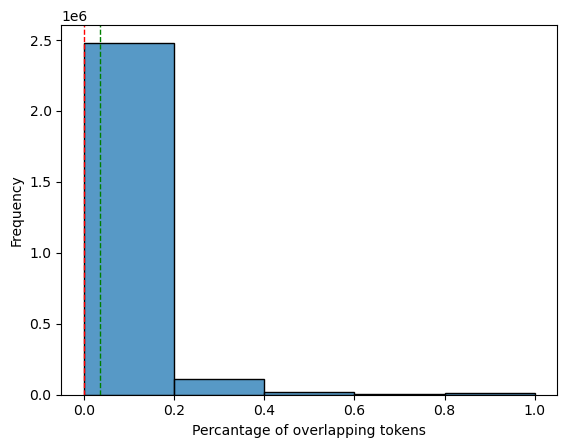

In [138]:
all_overlaps = [item for sublist in data["overlap"] for item in sublist]
# Histogram of overlap percentages
sns.histplot(all_overlaps, bins=5)
# median line
plt.axvline(median(all_overlaps), color='r', linestyle='dashed', linewidth=1)
# mean line
plt.axvline(mean(all_overlaps), color='g', linestyle='dashed', linewidth=1)
plt.xlabel("Percantage of overlapping tokens")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.show()

In [139]:
from sentence_transformers import SentenceTransformer

In [142]:
sent_model = SentenceTransformer('distiluse-base-multilingual-cased')
tokenizer = sent_model.tokenizer

In [ ]:
sent_model.

In [151]:

enc = sent_model.encode(gnd_df["pref"].values)
#sent_model.similarity(enc, enc)

In [153]:
enc.shape

(346145, 512)

In [156]:
enc_title = sent_model.encode(data["title"].values, batch_size=256, show_progress_bar=True)

Batches:   0%|          | 0/3716 [00:00<?, ?it/s]

In [177]:
idn2index = {idn[0]: idn[1] for idn in gnd_df.index}

In [180]:
sims = []
for title in tqdm(data.itertuples()):
    index = title.Index
    labels = title._2
    for l in labels:
        l_index = idn2index.get(l, None)
        if l_index is None:
            continue
        sim = sent_model.similarity(enc_title[index], enc[l_index])
        sims.append(sim[0][0])

951103it [03:45, 4219.47it/s]


In [183]:
sims = [float(sim) for sim in sims]

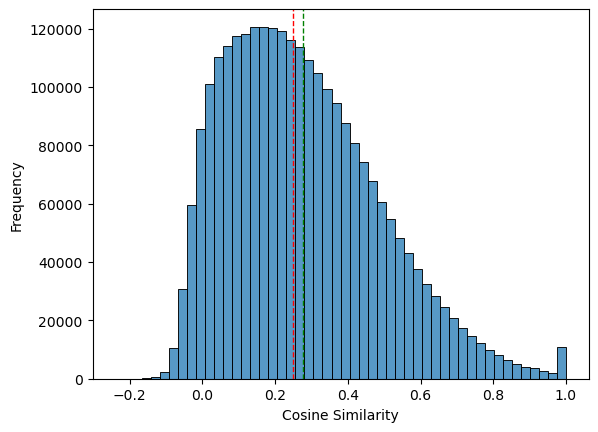

In [188]:
sns.histplot(sims, bins=50)
plt.axvline(mean(sims), color='g', linestyle='dashed', linewidth=1)
plt.axvline(median(sims), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [190]:
import random

In [191]:
sims_random = []
for title in tqdm(data.itertuples()):
    index = title.Index
    labels = random.sample(range(gnd_df.shape[0]), 2)
    for l in labels:
        sim = sent_model.similarity(enc_title[index], enc[l])
        sims_random.append(sim[0][0])

951103it [03:07, 5060.17it/s]


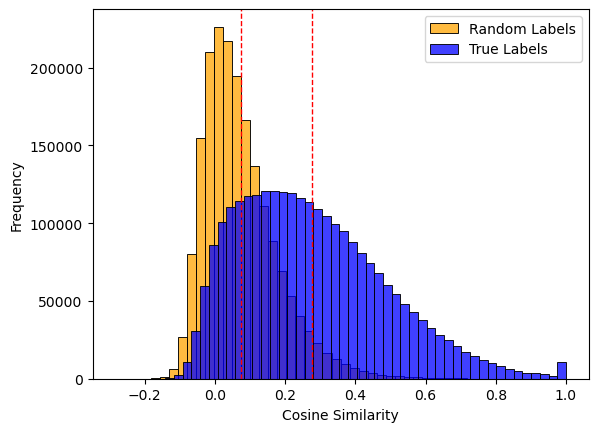

In [197]:
sims_random = [float(sim) for sim in sims_random]
sns.histplot(sims_random, bins=50, color='orange')
sns.histplot(sims, bins=50, color='blue')
plt.legend(["Random Labels", "True Labels"])
plt.axvline(mean(sims_random), color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean(sims), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()